In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal
from utils import audio, channels, synchronize, channel_estimate

cwd = os.getcwd()

In [2]:
# Sync with chirp through octagon
chirp_duration = 1
fs = 48000
double_chirp = True

sample_times = np.linspace(0, chirp_duration, fs * chirp_duration)
chirp = scipy.signal.chirp(sample_times, 0, chirp_duration, 240000)
reverse_chirp = chirp[::-1]

if double_chirp:
    received_signal, samplerate = audio.wav_to_signal("double_chirp_octagon", os.path.join(cwd, "audio_files"))
else:
    received_signal, samplerate = audio.wav_to_signal("single_chirp_octagon", os.path.join(cwd, "audio_files"))

convolved = np.convolve(received_signal, reverse_chirp)

plt.plot(convolved)
plt.show(block=False)



FileNotFoundError: [Errno 2] No such file or directory: 'c:\\personal files\\study\\Part IIA\\GF3 Audio modem\\code\\IIA_Project_GF3_Group_1\\audio_files\\double_chirp_octagon.wav'

In [3]:
#baisc parameter definition
chirp_duration = 1
record_duration = 7
fs = 48000

#define chirp used in the signal
sample_times = np.linspace(0, chirp_duration, fs * chirp_duration)
chirp_range=[20,20000]
chirp = scipy.signal.chirp(sample_times, chirp_range[0], chirp_duration, chirp_range[1])
filename = 'single_chirp_0524_7'

Start recording for 7 seconds...
Finish recording


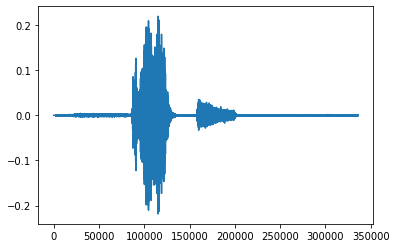

In [4]:
#record and save
received_signal = audio.record(record_duration, fs)
audio.signal_to_wav(received_signal,fs,filename,"audio_files")#  save recorded audio
#single_chirp_0524 0-24k, single_chirp_0524_2 20-20k, single_chirp_0524_3 20-20k, single_chirp_0524_4 20-20k 
#single_chirp_0524_5 20-20k chirp + ws, single_chirp_0524_6 20-20k chirp, ingle_chirp_0524_7 20-20k chirp + ws

#mdic = {"data": received_signal, "label": "record3"}
#scipy.io.savemat('record3.mat', mdic)

In [ ]:
#load recorded signals
received_signal,_ = np.array(audio.wav_to_signal(filename,'audio_files'))

In [5]:
#synchronize: convolve and find
start,convolved = synchronize.chirp_synchronize(received_signal,chirp_range, fs,duration=1)
event_end = np.array(synchronize.impulse_detect(convolved,fs,duration = 1,window_time=0.1,threshold=2))

[134327] [] nan


C:\Program Files\Python310\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Program Files\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


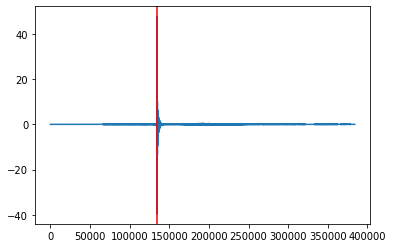

In [6]:
#plot the convolved result
diff = event_end[1:]-event_end[:-1]
print(event_end, diff, np.mean(diff))

plt.plot(convolved)
for pos in event_end:
    plt.axvline(x = pos, color = 'r')
plt.show()

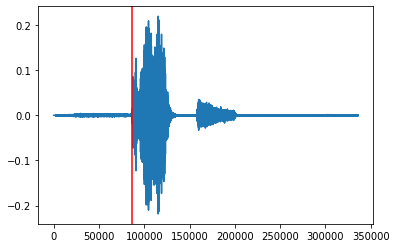

In [7]:
#plot found chirp in received signal
event_start = event_end - fs*chirp_duration
plt.plot(received_signal)
for pos in event_start:
    plt.axvline(x = pos, color = 'r')
plt.show()
event = event_start

C:\Program Files\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'method 3 estimation single_chirp_0524_7')

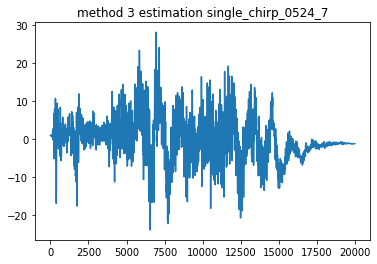

In [8]:
# estimate with method 3
chirp_received = received_signal[event[0]:event[0]+chirp_duration*fs]
reverse_chirp = chirp[::-1]
estimate = channel_estimate.channelest3(reverse_chirp,chirp_received,fs,hsize=fs)

plt.plot(np.fft.fft(estimate)[:20000])
plt.title('method 3 estimation '+filename)

C:\Program Files\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'method 1 estimation single_chirp_0524_7')

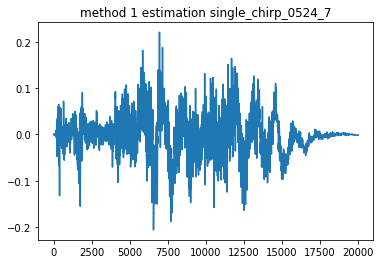

In [47]:
#estimate with method 1, direct division
Y = np.fft.fft(chirp_received)
X = np.fft.fft(chirp)

h = np.fft.ifft((Y/X))
H_trimmed = (Y/X)[:20000]

plt.plot(H_trimmed)
plt.title('method 1 estimation '+filename)

C:\Program Files\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'method 1 estimation single_chirp_0524_7')

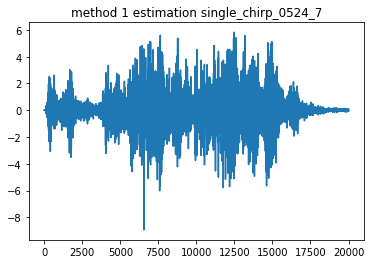

In [10]:
#estimate with method 1, direct division, for use of white noise signal
wn_duration = 1
interval = 1.5  #start of chirp to start of white noise
wn_received = received_signal[event[0]+int(interval*fs):event[0]+int((wn_duration+interval)*fs)]
Y = np.fft.fft(wn_received)
X = np.ones(np.shape(wn_received))  #ideal white noise fft constant, doens't matter 

h = np.fft.ifft((Y/X))
H_trimmed = (Y/X)[:20000]

plt.plot(H_trimmed)
plt.title('method 1 estimation '+filename)

In [18]:
#windowed method 1
def windowing(signal,wsize,overlap):
    signal_pad = np.concatenate((signal,np.zeros(wsize)))
    wnum = int((np.size(signal)-wsize)/overlap)+1
    starts = np.array([ i*overlap for i in range(wnum)])
    ends = starts + wsize
    windows = [ signal_pad[starts[i]:ends[i]] for i in range(wnum) ]
    return windows

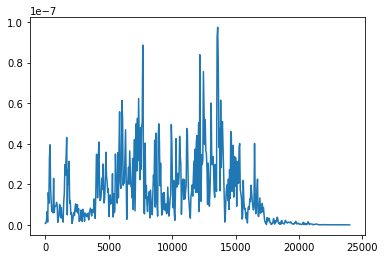

In [45]:
#estimate with scd function
f, Pxy = scipy.signal.csd(np.random.randn(np.size(wn_received)), wn_received, fs, nperseg=1024)
plt.plot(f, abs(Pxy))

(5000,)


C:\Program Files\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


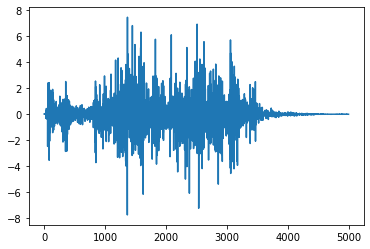

In [35]:
wsize = 10000
overlap = 6667
y_windowed = windowing(wn_received,wsize,overlap)
Y = np.fft.fft(y_windowed)  #need to check axis
X = np.ones(np.shape(Y))
H_trimmed = np.sum((Y/X)[:,:int(wsize/2)],axis = 0)
print(np.shape(H_trimmed))
plt.plot(H_trimmed)
h = np.fft.ifft((Y/X))  #check axis

other random plot below, no need to look

In [ ]:
hsize = 500
received_cropped = received_signal[event[0]:event[0]+chirp_duration*fs + hsize]
ax = plt.subplot(221)
ax.plot(channel_estimate.channelest1(chirp,received_cropped,10,10+hsize,5)[:500])

hsize = 800
received_cropped = received_signal[event[0]:event[0]+chirp_duration*fs + hsize]
ax = plt.subplot(222)
ax.plot(channel_estimate.channelest1(chirp,received_cropped,10,10+hsize,5)[:500])

hsize = 2000
ax = plt.subplot(223)
received_cropped = received_signal[event[0]:event[0]+chirp_duration*fs + hsize]
ax.plot(channel_estimate.channelest1(chirp,received_cropped,10,10+hsize,5)[:500])

hsize = 5000
ax = plt.subplot(224)
received_cropped = received_signal[event[0]:event[0]+chirp_duration*fs + hsize]
ax.plot(channel_estimate.channelest1(chirp,received_cropped, 10,10+hsize,5)[:500])
 

In [ ]:
estimate = channel_estimate.channelest3(reverse_chirp,chirp_received,fs,hsize=100)
ax = plt.subplot(221)
ax.plot(channel_estimate.channelest3(reverse_chirp,chirp_received,fs,hsize=100)[:500])
ax = plt.subplot(222)
ax.plot(channel_estimate.channelest3(reverse_chirp,chirp_received,fs,hsize=500)[:500])
ax = plt.subplot(223)
ax.plot(channel_estimate.channelest3(reverse_chirp,chirp_received,fs,hsize=8000)[:500])
ax = plt.subplot(224)
ax.plot(channel_estimate.channelest3(reverse_chirp,chirp_received,fs,hsize=1000)[:500])

In [ ]:
hsize = 10000
received_cropped = received_signal[event[0]:event[0]+chirp_duration*fs + hsize]
estimate = channel_estimate.channelest1(chirp,received_cropped, 10,10+hsize,5)
plt.plot(np.fft.fft(estimate[:int(len(estimate)/2)]))
#plt.plot(abs(estimate))

In [ ]:
hsize = 48000
xwin = 48000
received_cropped = received_signal[event[0]:event[0]+chirp_duration*fs + hsize]
plt.plot(channel_estimate.channelest1(chirp,received_cropped, xwin,xwin+hsize,10)[:500])